In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import json
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,Flatten, GlobalAveragePooling2D, Concatenate, Dropout, BatchNormalization, concatenate
from tensorflow.keras.utils import Sequence,to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df_business = pd.read_csv('yelp_academic_dataset_business.csv')
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [3]:
photo_path = r"C:\Users\theja\OneDrive - Loyalist College\CV\yelp_photos\photos"
photos_df = pd.read_json('photos.json', lines=True)
photos_df.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [4]:
photos_df['label' ].unique()

array(['inside', 'outside', 'drink', 'food', 'menu'], dtype=object)

In [5]:
df_business.shape

(150346, 14)

In [6]:
photos_df.shape

(200100, 4)

In [7]:
if 'category' in photos_df.columns:
    label_column = 'category'
elif 'label' in photos_df.columns:
    label_column = 'label'
else:
    raise ValueError("The JSON file does not contain a label column.")

C:\Users\theja\AppData\Local\Temp\ipykernel_20780\3666958647.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(label_counts))


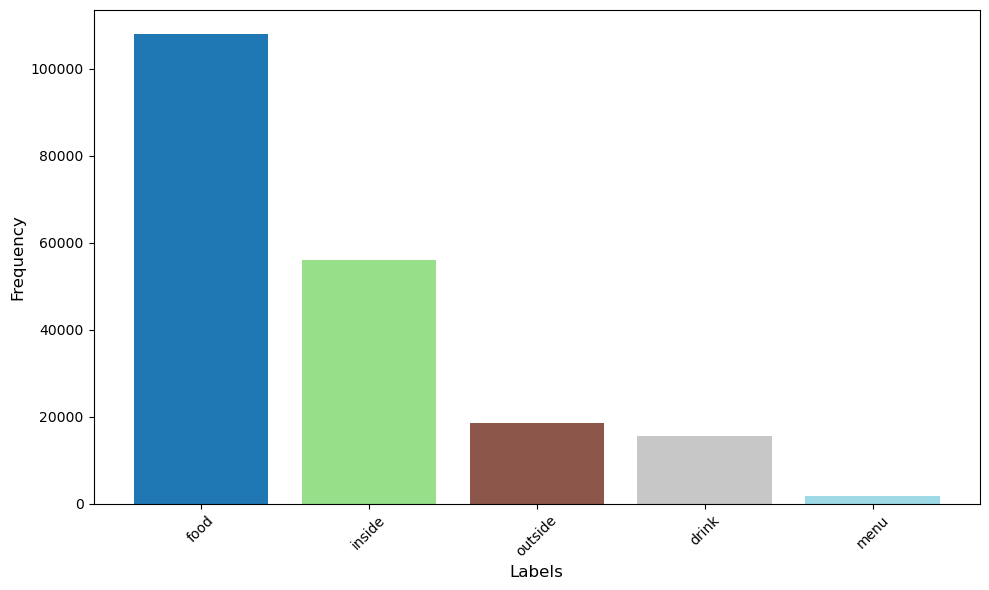

In [8]:
label_counts = photos_df[label_column].value_counts()
colors = plt.cm.get_cmap("tab20", len(label_counts))
color_list = [colors(i) for i in range(len(label_counts))]
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=color_list)
plt.xlabel("Labels", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
image_dir = r"C:\Users\theja\OneDrive - Loyalist College\CV\yelp_photos\photos"

In [10]:
output_base = r"C:\Users\theja\OneDrive - Loyalist College\CV\yelp_photos\processed"

In [11]:
valid_labels = ['inside', 'outside', 'food', 'drink', 'menu']
photos_df = photos_df[photos_df['label'].isin(valid_labels)]

In [12]:
# # comment
# import os
# import pandas as pd
# import shutil
# from sklearn.model_selection import train_test_split

# # Path where images are stored
# image_dir = r"C:\Users\theja\OneDrive - Loyalist College\CV\yelp_photos\photos"

# # Output base directory
# output_base = r"C:\Users\theja\OneDrive - Loyalist College\CV\yelp_photos\processed"

# # Load your dataframe (replace with your actual CSV if needed)
# # For example: photos_df = pd.read_csv('photos.csv')
# # Assuming you've already loaded it as photos_df

# # Filter to only use the valid labels
# valid_labels = ['inside', 'outside', 'food', 'drink', 'menu']
# photos_df = photos_df[photos_df['label'].isin(valid_labels)]

# # Create train/test split per label
# for label in valid_labels:
#     label_df = photos_df[photos_df['label'] == label]
    
#     # Split into train and test
#     train_df, test_df = train_test_split(label_df, test_size=0.2, random_state=42)

#     # Create target directories
#     train_label_dir = os.path.join(output_base, 'train', label)
#     test_label_dir = os.path.join(output_base, 'test', label)
#     os.makedirs(train_label_dir, exist_ok=True)
#     os.makedirs(test_label_dir, exist_ok=True)

#     # Move train images
#     for photo_id in train_df['photo_id']:
#         src = os.path.join(image_dir, f"{photo_id}.jpg")
#         dst = os.path.join(train_label_dir, f"{photo_id}.jpg")
#         if os.path.exists(src):
#             shutil.copy(src, dst)

#     # Move test images
#     for photo_id in test_df['photo_id']:
#         src = os.path.join(image_dir, f"{photo_id}.jpg")
#         dst = os.path.join(test_label_dir, f"{photo_id}.jpg")
#         if os.path.exists(src):
#             shutil.copy(src, dst)

# print("✅ Image folders created and populated successfully.")

In [13]:
df = photos_df.merge(df_business[['business_id', 'categories']], on='business_id', how='left')

In [14]:
df.head()

,photo_id,business_id,caption,label,categories
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside,"Restaurants, Pubs, Nightlife, American (Tradit..."
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside,"Barbeque, Sandwiches, American (Traditional), ..."
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink,"Live/Raw Food, Seafood, Restaurants, Cajun/Creole"
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food,"Live/Raw Food, Restaurants, Seafood, Beer Bar,..."
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food,"Restaurants, Vegan, Food, Ice Cream & Frozen Y..."


In [15]:
df.drop(["business_id","caption"],axis=1,inplace=True)

In [16]:
df.head()

,photo_id,label,categories
0,zsvj7vloL4L5jhYyPIuVwg,inside,"Restaurants, Pubs, Nightlife, American (Tradit..."
1,HCUdRJHHm_e0OCTlZetGLg,outside,"Barbeque, Sandwiches, American (Traditional), ..."
2,vkr8T0scuJmGVvN2HJelEA,drink,"Live/Raw Food, Seafood, Restaurants, Cajun/Creole"
3,pve7D6NUrafHW3EAORubyw,food,"Live/Raw Food, Restaurants, Seafood, Beer Bar,..."
4,H52Er-uBg6rNrHcReWTD2w,food,"Restaurants, Vegan, Food, Ice Cream & Frozen Y..."


In [17]:
df['label'].value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

In [18]:
Processed_Files_Path = r"C:\Users\theja\OneDrive - Loyalist College\CV\yelp_photos\processed"
Photos_path = r"C:\Users\theja\OneDrive - Loyalist College\CV\yelp_photos\photos"
TRAIN_DIR = os.path.join(Processed_Files_Path, "train")
TEST_DIR = os.path.join(Processed_Files_Path, "test")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [19]:
df = df.dropna(subset=['label', 'photo_id'])

In [20]:
df["image_path"] = df["photo_id"].apply(lambda x: os.path.join(Photos_path, f"{x}.jpg"))

In [21]:
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])

In [22]:
tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(df["categories"].fillna(""))

In [23]:
metadata_seq = tokenizer.texts_to_matrix(df["categories"].fillna(""), mode='binary')
metadata_dim = metadata_seq.shape[1]

In [24]:
def preprocess_image(path, target_size=(224, 224)):
    image = cv2.imread(path)

    if image is None:
        return np.zeros((*target_size, 3))

    image = cv2.resize(image, target_size)
    image = cv2.GaussianBlur(image, (3, 3), 0)

    yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])
    image = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
    image[mask == 0] = 0

    return image.astype(np.float32) / 255.0

In [25]:
class ImageOnlyGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=32, target_size=(224,224), augment=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.augment = augment
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = [self.load_and_preprocess(p) for p in batch_paths]
        
        return np.array(images, dtype=np.float32), np.array(batch_labels, dtype=np.int32)
    
    def load_and_preprocess(self, path):
        # Load image from path and resize etc.
        # Add augmentation if self.augment True
        image = preprocess_image(path, self.target_size)
        if self.augment:
            if np.random.rand() < 0.5:
                image = np.fliplr(image)
            if np.random.rand() < 0.5:
                angle = np.random.uniform(-15, 15)
                M = cv2.getRotationMatrix2D((self.target_size[0]//2, self.target_size[1]//2), angle, 1)
                image = cv2.warpAffine(image, M, self.target_size)
        return image


In [26]:
X_img = df["image_path"].values
X_meta = metadata_seq
y = df["label_encoded"].values

In [27]:
X_img_train, X_img_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(
    X_img, X_meta, y, test_size=0.2, stratify=y, random_state=42)

In [28]:
from sklearn.utils import resample

In [29]:
def balanced_sample_images_only(X_img, y, samples_per_class=1678):
    df = pd.DataFrame({
        'img': X_img,
        'label': y
    })

    unique_labels = np.unique(y)
    balanced_parts = []

    for label in unique_labels:
        class_df = df[df['label'] == label]
        if len(class_df) >= samples_per_class:
            class_sample = resample(class_df, n_samples=samples_per_class, random_state=42, replace=False)
        else:
            # If not enough samples, resample with replacement
            class_sample = resample(class_df, n_samples=samples_per_class, random_state=42, replace=True)
        balanced_parts.append(class_sample)

    balanced_df = pd.concat(balanced_parts).sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_df['img'].values, balanced_df['label'].values

In [30]:
X_img_train_bal, y_train_bal = balanced_sample_images_only(X_img_train, y_train, samples_per_class=1342)
X_img_val_bal, y_val_bal = balanced_sample_images_only(X_img_val, y_val, samples_per_class=336)

In [31]:
# Use balanced data here
train_gen = ImageOnlyGenerator(X_img_train_bal, y_train_bal, augment=True)
val_gen = ImageOnlyGenerator(X_img_val_bal,  y_val_bal, augment=False)

In [32]:
print(f"Metadata feature size: {metadata_dim}")
print(f"Train batches: {len(train_gen)}, Validation batches: {len(val_gen)}")

Metadata feature size: 500
Train batches: 210, Validation batches: 53


In [33]:
print(f"🔢 Total training samples: {len(train_gen) * train_gen.batch_size}")
print(f"🔢 Total validation samples: {len(val_gen) * val_gen.batch_size}")

🔢 Total training samples: 6720
🔢 Total validation samples: 1696


# VGG Model

In [34]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import time

In [35]:
# Input
image_input = Input(shape=(224, 224, 3), name='image_input')

In [36]:
# Load VGG16 and freeze all layers
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)
for layer in base_model.layers:
    layer.trainable = False

In [37]:
# Global average pooling to flatten
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Final classification layer (no extra dense layers)
output = Dense(len(label_encoder.classes_), activation='softmax')(x)


In [38]:
# Build and compile model
model = Model(inputs=image_input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           2,5

 Total params: 14,717,253 (56.14 MB)

 Trainable params: 2,565 (10.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [40]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_vgg_model.keras', save_best_only=True, monitor='val_loss')


In [41]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
# Train (feature extraction)
start = time.time()
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)
end = time.time()
print(f"Training time: {(end - start) / 60:.2f} mins")

Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 3497s 17s/step - accuracy: 0.5113 - loss: 1.3470 - val_accuracy: 0.7488 - val_loss: 0.8684 - learning_rate: 0.0010
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 3126s 15s/step - accuracy: 0.7246 - loss: 0.8698 - val_accuracy: 0.7601 - val_loss: 0.7261 - learning_rate: 0.0010
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2195s 10s/step - accuracy: 0.7546 - loss: 0.7459 - val_accuracy: 0.7750 - val_loss: 0.6657 - learning_rate: 0.0010
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1883s 9s/step - accuracy: 0.7504 - loss: 0.7130 - val_accuracy: 0.7863 - val_loss: 0.6257 - learning_rate: 0.0010
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1829s 9s/step - accuracy: 0.7617 - loss: 0.6682 - val_accuracy: 0.7863 - val_loss: 0.6025 - learning_rate: 0.0010
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1850s 9s/step - accuracy: 0.7840 - loss: 0.6411 - val_accuracy: 0.7923 - val_loss: 0.5834 - learning_rate: 0.0010
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1844s 9s/step - accuracy: 0.7781 

In [45]:
# Evaluate on training data
train_loss, train_accuracy = model.evaluate(train_gen)
print(f"Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}")

210/210 ━━━━━━━━━━━━━━━━━━━━ 1450s 7s/step - accuracy: 0.7947 - loss: 0.5678
Train Accuracy: 0.8033, Train Loss: 0.5572


In [46]:
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Test Accuracy: {val_accuracy:.4f}, Test Loss: {val_loss:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 359s 7s/step - accuracy: 0.8206 - loss: 0.5163
Test Accuracy: 0.8060, Test Loss: 0.5423


In [47]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt
import numpy as np


In [48]:
# Predict probabilities
y_train_probs = model.predict(train_gen)
y_val_probs = model.predict(val_gen)

# Predicted class labels
y_train_pred = np.argmax(y_train_probs, axis=1)
y_val_pred = np.argmax(y_val_probs, axis=1)

# True labels
y_train_true = y_train_bal
y_val_true = y_val_bal


210/210 ━━━━━━━━━━━━━━━━━━━━ 1443s 7s/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 360s 7s/step


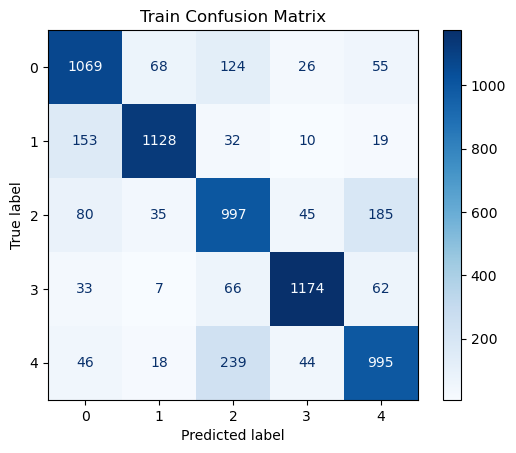

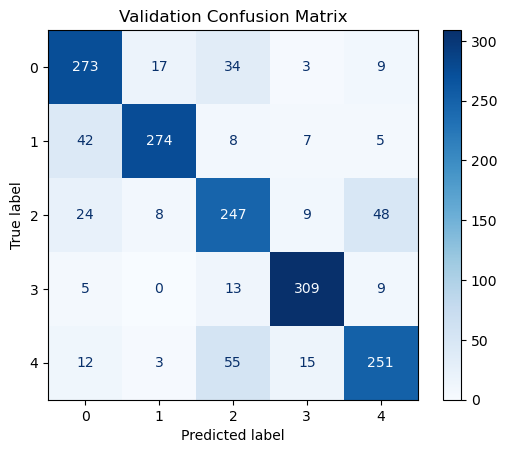

In [49]:
# Confusion Matrix for Train
cm_train = confusion_matrix(y_train_true, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Train Confusion Matrix")
plt.show()

# Confusion Matrix for Validation
cm_val = confusion_matrix(y_val_true, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()


In [50]:
# Convert labels to one-hot if needed
from sklearn.preprocessing import label_binarize
num_classes = len(np.unique(y_train_true))

y_train_true_bin = label_binarize(y_train_true, classes=range(num_classes))
y_val_true_bin = label_binarize(y_val_true, classes=range(num_classes))

train_auc = roc_auc_score(y_train_true_bin, y_train_probs, average="macro", multi_class='ovr')
val_auc = roc_auc_score(y_val_true_bin, y_val_probs, average="macro", multi_class='ovr')

print(f"✅ Train AUC (macro): {train_auc:.4f}")
print(f"✅ Validation AUC (macro): {val_auc:.4f}")


✅ Train AUC (macro): 0.9592
✅ Validation AUC (macro): 0.9600


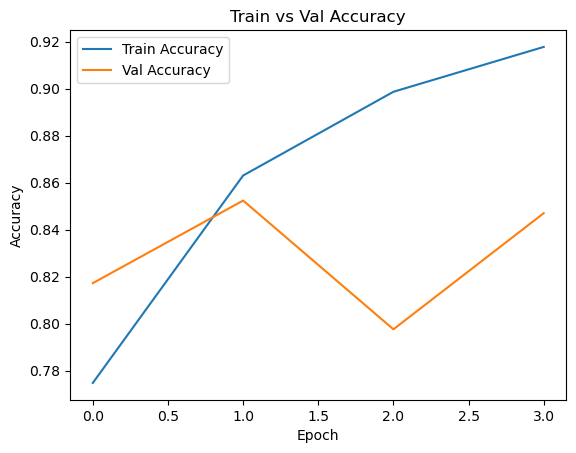

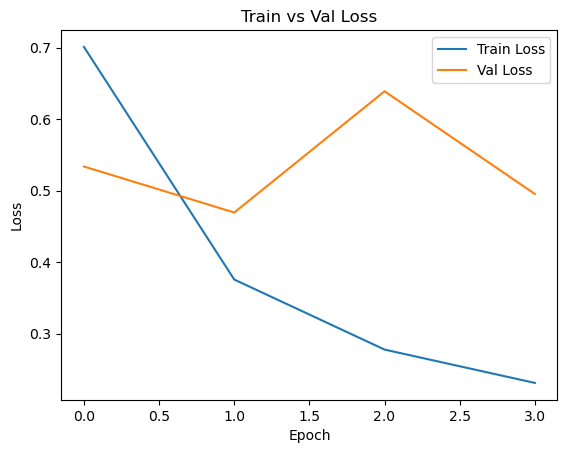

In [88]:
#8. Overfitting Plot
# =============================

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Val Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()
plt.show()

# Fine Tuning

In [51]:
# ---- Unfreeze top layers ----
base_model.trainable = True

In [52]:
fine_tune_at = 10  
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [53]:
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [54]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           2,5

 Total params: 14,717,253 (56.14 MB)

 Trainable params: 2,565 (10.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [55]:
# fine-tuning 
start_time = time.time()
history_ft =model.fit(train_gen, validation_data=val_gen, epochs=10,
          callbacks=[
              EarlyStopping(patience=2, monitor='val_loss', restore_best_weights=True),
              ReduceLROnPlateau(patience=2, monitor='val_loss'),
              ModelCheckpoint('vgg_finetuned.keras', save_best_only=True)
          ])
end_time = time.time()
elapsed_time = end_time - start_time

Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1829s 9s/step - accuracy: 0.8013 - loss: 0.5526 - val_accuracy: 0.8089 - val_loss: 0.5406 - learning_rate: 1.0000e-05
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1819s 9s/step - accuracy: 0.8075 - loss: 0.5327 - val_accuracy: 0.8077 - val_loss: 0.5398 - learning_rate: 1.0000e-05
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1820s 9s/step - accuracy: 0.7942 - loss: 0.5694 - val_accuracy: 0.8089 - val_loss: 0.5393 - learning_rate: 1.0000e-05
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1797s 9s/step - accuracy: 0.8021 - loss: 0.5659 - val_accuracy: 0.8095 - val_loss: 0.5391 - learning_rate: 1.0000e-05
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1798s 9s/step - accuracy: 0.8011 - loss: 0.5624 - val_accuracy: 0.8089 - val_loss: 0.5389 - learning_rate: 1.0000e-05
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1790s 9s/step - accuracy: 0.7959 - loss: 0.5632 - val_accuracy: 0.8089 - val_loss: 0.5388 - learning_rate: 1.0000e-05
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1807s 9s/ste

In [79]:
# Evaluate on training data
train_loss, train_accuracy = model.evaluate(train_gen)
print(f"Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}")

210/210 ━━━━━━━━━━━━━━━━━━━━ 1141s 5s/step - accuracy: 0.7957 - loss: 0.5633
Train Accuracy: 0.8016, Train Loss: 0.5566


In [80]:
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Test Accuracy: {val_accuracy:.4f}, Test Loss: {val_loss:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 298s 6s/step - accuracy: 0.8181 - loss: 0.5121
Test Accuracy: 0.8083, Test Loss: 0.5385


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt
import numpy as np


In [74]:
# Predict probabilities
y_train_probs = model.predict(train_gen)
y_val_probs = model.predict(val_gen)

# Predicted class labels
y_train_pred = np.argmax(y_train_probs, axis=1)
y_val_pred = np.argmax(y_val_probs, axis=1)

# True labels
y_train_true = y_train_bal
y_val_true = y_val_bal


210/210 ━━━━━━━━━━━━━━━━━━━━ 1119s 5s/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 289s 5s/step


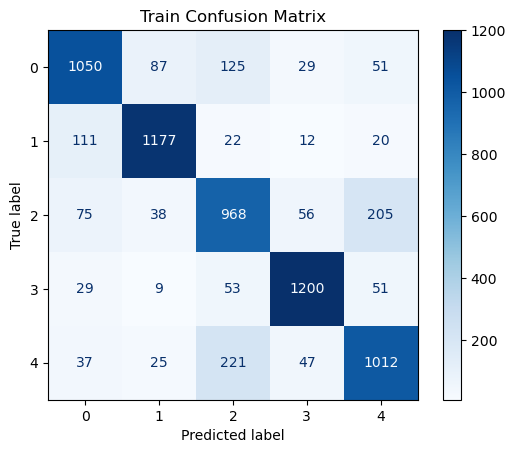

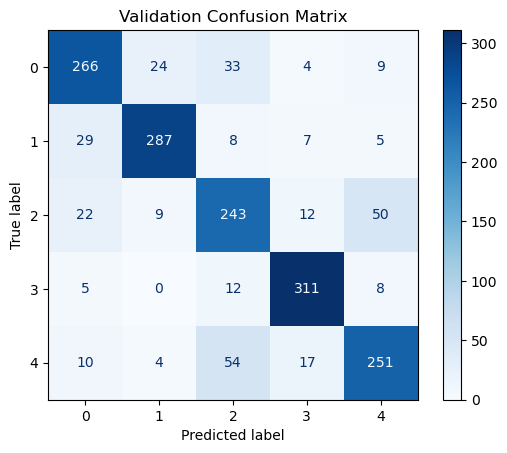

In [75]:
# Confusion Matrix for Train
cm_train = confusion_matrix(y_train_true, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Train Confusion Matrix")
plt.show()

# Confusion Matrix for Validation
cm_val = confusion_matrix(y_val_true, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()


In [76]:
# Convert labels to one-hot if needed
from sklearn.preprocessing import label_binarize
num_classes = len(np.unique(y_train_true))

y_train_true_bin = label_binarize(y_train_true, classes=range(num_classes))
y_val_true_bin = label_binarize(y_val_true, classes=range(num_classes))

train_auc = roc_auc_score(y_train_true_bin, y_train_probs, average="macro", multi_class='ovr')
val_auc = roc_auc_score(y_val_true_bin, y_val_probs, average="macro", multi_class='ovr')

print(f"✅ Train AUC (macro): {train_auc:.4f}")
print(f"✅ Validation AUC (macro): {val_auc:.4f}")


✅ Train AUC (macro): 0.9599
✅ Validation AUC (macro): 0.9601


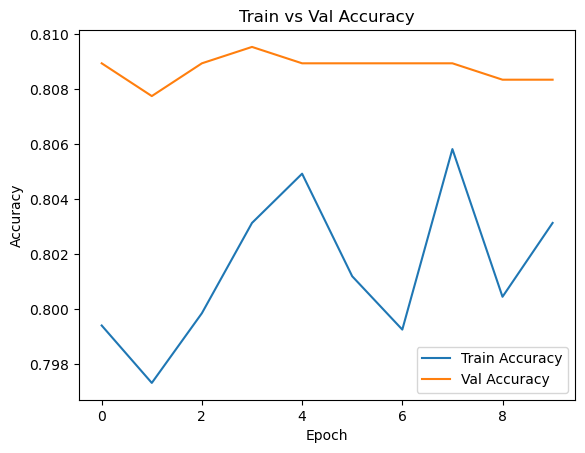

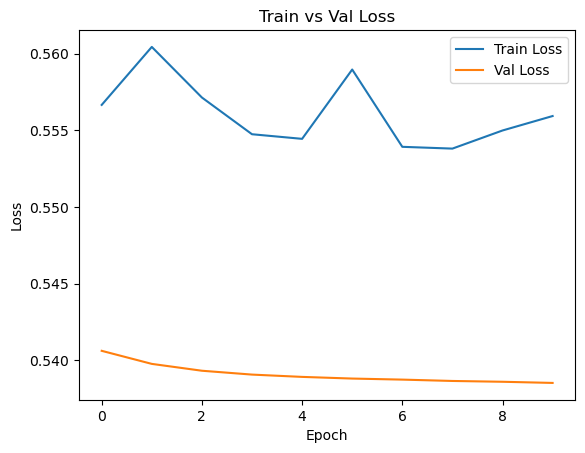

In [82]:
#8. Overfitting Plot
# =============================

plt.plot(history_ft.history['accuracy'], label='Train Accuracy')
plt.plot(history_ft.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Val Accuracy')
plt.legend()
plt.show()

plt.plot(history_ft.history['loss'], label='Train Loss')
plt.plot(history_ft.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()
plt.show()

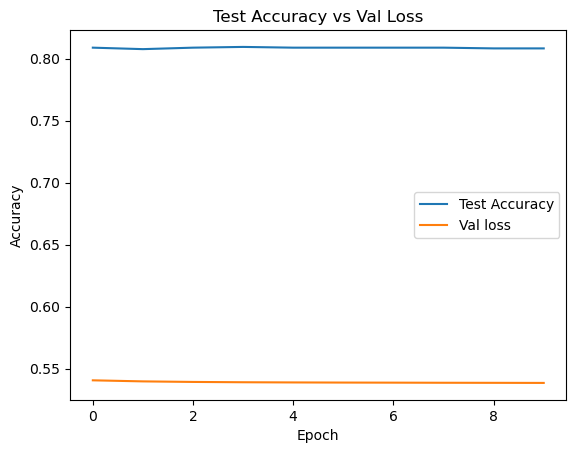

In [86]:
#8. Overfitting Plot
# =============================

plt.plot(history_ft.history['val_accuracy'], label='Test Accuracy')
plt.plot(history_ft.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Val Loss')
plt.legend()
plt.show()

# plt.plot(history_ft.history['loss'], label='Train Loss')
# plt.plot(history_ft.history['val_loss'], label='Val Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Train vs Val Loss')
# plt.legend()
# plt.show()